In [1]:
import argparse
import os
import json
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

from watermarks.kgw.watermark_processor import WatermarkDetector
from watermarks.aar.aar_watermark import AarWatermarkDetector
from watermarks.watermark_types import WatermarkType

DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,3"

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
with open("/remote-home/miintern1/watermark-learnability/data/c4/generate_and_evaluate_c4.json", "r") as f:
    data = json.load(f)


In [4]:
from pprint import pprint
pprint(list(data['samples'].keys()))

['llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1',
 'llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2',
 'llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2',
 'llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1',
 'llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2']


In [5]:
# print(data['samples']['llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1']['watermark_config'])
for model_name in data['samples']:
    print(model_name)
    print(data['samples'][model_name]['watermark_config']) if 'watermark_config' in data['samples'][model_name] else None
    print()

llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1
{'type': 'kgw', 'k': 1, 'gamma': 0.25, 'delta': 1.0, 'seeding_scheme': 'simple_1', 'kgw_device': 'cpu'}

llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2
{'type': 'kgw', 'k': 2, 'gamma': 0.25, 'delta': 2.0, 'seeding_scheme': 'simple_2', 'kgw_device': 'cpu'}

llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2
{'type': 'kgw', 'k': 1, 'gamma': 0.25, 'delta': 2.0, 'seeding_scheme': 'simple_1', 'kgw_device': 'cpu'}

llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1
{'type': 'kgw', 'k': 0, 'gamma': 0.25, 'delta': 1.0, 'seeding_scheme': 'simple_0', 'kgw_device': 'cpu'}

llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2
{'type': 'kgw', 'k': 0, 'gamma': 0.25, 'delta': 2.0, 'seeding_scheme': 'simple_0', 'kgw_device': 'cpu'}



In [7]:
watermark_config = data['samples']['llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1']['watermark_config']

In [8]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')
watermark_type = WatermarkType.KGW
detector = WatermarkDetector(
    device=watermark_config.get("kgw_device", 'cpu'),
    tokenizer=tokenizer,
    vocab=tokenizer.get_vocab().values(),
    gamma=watermark_config["gamma"],
    seeding_scheme=watermark_config["seeding_scheme"],
    normalizers=[],
)
model_samples = data['samples']['llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1']['model_text']
human_samples = data['samples']['llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1']['human_text']
model_scores = []
human_scores = []
for sample in tqdm(model_samples):
    score = detector.detect(sample)
    model_scores.append(score['p_value'])
for sample in tqdm(human_samples):
    score = detector.detect(sample)
    human_scores.append(score['p_value'])
    

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 5000/5000 [01:47<00:00, 46.47it/s]


In [10]:
import statistics
# Calculate basic statistics
mean = statistics.mean(model_scores)
median = statistics.median(model_scores)
stdev = statistics.stdev(model_scores)
minimum = min(model_scores)
maximum = max(model_scores)

# Print the results
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {stdev}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")


Mean: 0.055517685173941324
Median: 0.005984616771209155
Standard Deviation: 0.12086854164156544
Minimum: 4.665963805281391e-13
Maximum: 0.9950983372348507


In [1]:
# Load model directly
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode to 2
%autoreload 2
import argparse
import os
os.environ['http_proxy'] = "http://10.176.52.116:7890"
os.environ['https_proxy'] = "http://10.176.52.116:7890"
os.environ['all_proxy'] = "socks5://10.176.52.116:7891"
import sys
sys.path.append(('../'))
sys.path.append(('../../'))
import json
from typing import Dict
import torch
from datasets import load_dataset
from tqdm import tqdm
import numpy
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from task_vector import TaskVector

from watermarks.kgw.watermark_processor import WatermarkDetector
from watermarks.aar.aar_watermark import AarWatermarkDetector
from watermarks.watermark_types import WatermarkType

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1")
watermarked_model = AutoModelForCausalLM.from_pretrained("cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1")
vanilla_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c1

In [3]:
watermark_config = {"type": "kgw", "k": 0, "gamma": 0.25, "delta": 1.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"}

detector = WatermarkDetector(
                device=watermark_config.get("kgw_device", 'cpu'),
                tokenizer=tokenizer,
                vocab=tokenizer.get_vocab().values(),
                gamma=watermark_config["gamma"],
                seeding_scheme=watermark_config["seeding_scheme"],
                normalizers=[],
            )

In [4]:
task_vector = TaskVector(vanilla_model, watermarked_model)


In [5]:
print(task_vector.vector.keys()) 

dict_keys(['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.input_layernorm.weight', 'model.layers.1.post_attention_layernorm.weight', 'model.layers.2.self_attn.q_proj.weight', 'model.layers.2.self_attn.k_proj.weight', 'model.layers.2.self_attn.v_proj.weight', 'model.layers.2.self_attn.o_proj.weight', 'model.layers.2.mlp.gate_proj.weight', 'mode

In [6]:
# dataset = load_dataset("allenai/c4", "realnewslike", "validation")
dataset = load_dataset("allenai/c4", "realnewslike", split="validation", streaming="store_true")

In [7]:
max_length = 250
min_length = 250
num_samples = 100
device = 'cpu'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
def filter_length(example):
        return len(tokenizer(example['text'], truncation=True, max_length=max_length)["input_ids"]) >= min_length

def encode(examples):
    trunc_tokens = tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)
    # Examples are truncated to max_length, which comprises the possible generation prompt and the text to be generated
    examples["text"] = tokenizer.batch_decode(trunc_tokens["input_ids"], skip_special_tokens=True)
    prompt = tokenizer(
        examples["text"], truncation=True, padding=True, max_length=50, return_tensors="pt",
    ).to(device)
    examples["prompt_text"] = tokenizer.batch_decode(prompt["input_ids"], skip_special_tokens=True)
    examples["input_ids"] = prompt["input_ids"]
    examples["attention_mask"] = prompt["attention_mask"]
    examples["text_completion"] = tokenizer.batch_decode(
        trunc_tokens["input_ids"][:, 50:], skip_special_tokens=True
    )
    return examples

dataset = dataset.filter(filter_length)
# Set how many samples will be skipped
dataset = dataset.map(encode, batched=True)

dataloader = torch.utils.data.DataLoader(dataset, 16)

prompts = []
human_text = []
prompt_text = []
full_human_text = []
for batch in dataloader:
    if len(human_text) >= num_samples:
        break
    if (type(batch["input_ids"]) == list):
        batch["input_ids"] = torch.stack(batch["input_ids"], dim=1).to(device)
    if (type(batch["attention_mask"]) == list):
        batch["attention_mask"] = torch.stack(batch["attention_mask"], dim=1).to(device)
    prompts.append(batch)
    human_text.extend(batch["text_completion"])
    prompt_text.extend(batch["prompt_text"])
    full_human_text.extend(batch["text"])
human_text = human_text[:num_samples]
prompt_text = prompt_text[:num_samples]
full_human_text = full_human_text[:num_samples]
raw_input = {
    "prompts": prompts,
    "human_text": human_text,
    "prompt_text": prompt_text,
    "full_human_text": full_human_text,
}


Using pad_token, but it is not set yet.


In [19]:
DO_SAMPLE = True
temperature=1.0
top_p=0.9
top_k=0
vanilla_output_results = []
watermarked_output_results = []

coefficient = 0.1
coefficient_watermarked_model = task_vector.apply_to(vanilla_model, scaling_coef = coefficient)
for batch in tqdm(prompts):
    with torch.no_grad():
        vanilla_output = vanilla_model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    do_sample=DO_SAMPLE,
                    min_new_tokens=200,
                    max_new_tokens=200,
                    temperature=temperature,
                    top_p=top_p,
                    top_k=top_k,
                    pad_token_id=tokenizer.eos_token_id,
                )
        watermarked_output = watermarked_model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    do_sample=DO_SAMPLE,
                    min_new_tokens=200,
                    max_new_tokens=200,
                    temperature=temperature,
                    top_p=top_p,
                    top_k=top_k,
                    pad_token_id=tokenizer.eos_token_id,
                )
    break
n_input_tokens = batch["input_ids"].shape[1]
vanilla_output_results.extend(tokenizer.batch_decode(vanilla_output[:, n_input_tokens:], skip_special_tokens=True))
watermarked_output_results.extend(tokenizer.batch_decode(watermarked_output[:, n_input_tokens:], skip_special_tokens=True))

vanilla_output_results = vanilla_output_results[:num_samples]
watermarked_output_results = watermarked_output_results[:num_samples]

def compute_p_value(samples):
    score_list = []
    for s in tqdm(samples):
        score = detector.detect(s)
        score_list.append(score['p_value'])
    return score_list

vanilla_scores = compute_p_value(vanilla_output_results)
watermarked_scores = compute_p_value(watermarked_output_results)

100%|██████████| 16/16 [00:01<00:00, 15.37it/s]


In [22]:
print(watermarked_scores)

[0.012308539746637977, 3.6008151398279957e-06, 7.193361071692652e-06, 0.004363388017336873, 9.364978073223926e-05, 1.185855146094052e-09, 7.193361071692652e-06, 2.7542100548833858e-11, 8.380496965030422e-08, 0.0006094797744914687, 0.00016911265119370079, 1.7666461197620142e-06, 6.91125165250654e-09, 0.009178679390778589, 1.8800047124413736e-10, 0.00016911265119370079]


In [ ]:
import torch
from tqdm import tqdm

def evaluate_models_with_coefficients(task_vector, vanilla_model, tokenizer, prompts, coefficients, DO_SAMPLE, temperature, top_p, top_k, num_samples, detector):
    def compute_p_value(samples):
        score_list = []
        for s in tqdm(samples):
            score = detector.detect(s)
            score_list.append(score['p_value'])
        return score_list

    results = {}

    for coefficient in coefficients:
        # Apply the task vector with the current coefficient
        watermarked_model = task_vector.apply_to(vanilla_model, scaling_coef=coefficient)

        vanilla_output_results = []
        watermarked_output_results = []

        for batch in tqdm(prompts):
            with torch.no_grad():
                vanilla_output = vanilla_model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    do_sample=DO_SAMPLE,
                    min_new_tokens=200,
                    max_new_tokens=200,
                    temperature=temperature,
                    top_p=top_p,
                    top_k=top_k,
                    pad_token_id=tokenizer.eos_token_id,
                )
                watermarked_output = watermarked_model.generate(
                    input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    do_sample=DO_SAMPLE,
                    min_new_tokens=200,
                    max_new_tokens=200,
                    temperature=temperature,
                    top_p=top_p,
                    top_k=top_k,
                    pad_token_id=tokenizer.eos_token_id,
                )
            break  # Assuming you want to process only the first batch

        n_input_tokens = batch["input_ids"].shape[1]
        vanilla_output_results.extend(tokenizer.batch_decode(vanilla_output[:, n_input_tokens:], skip_special_tokens=True))
        watermarked_output_results.extend(tokenizer.batch_decode(watermarked_output[:, n_input_tokens:], skip_special_tokens=True))

        vanilla_output_results = vanilla_output_results[:num_samples]
        watermarked_output_results = watermarked_output_results[:num_samples]

        vanilla_scores = compute_p_value(vanilla_output_results)
        watermarked_scores = compute_p_value(watermarked_output_results)

        results[coefficient] = {
            "vanilla_scores": vanilla_scores,
            "watermarked_scores": watermarked_scores
        }

    return results


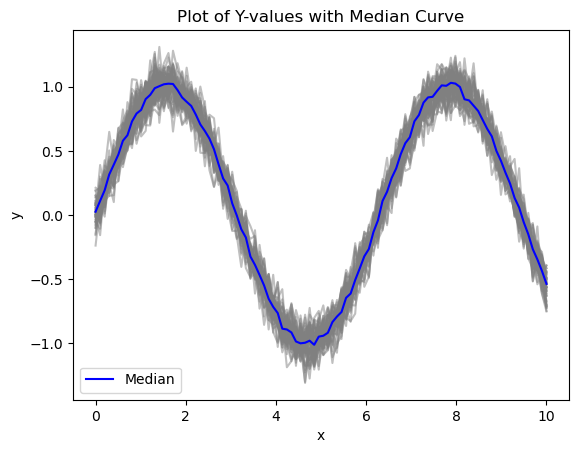

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 100)  # x-values
y_values = [np.sin(x) + np.random.normal(0, 0.1, 100) for _ in range(50)]  # List of y-values

# Calculate the median of y-values
y_median = np.median(y_values, axis=0)

# Plot all y-values in grey
for y in y_values:
    plt.plot(x, y, color='grey', alpha=0.5)

# Plot the median of y-values in blue
plt.plot(x, y_median, color='blue', label='Median')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of Y-values with Median Curve')
plt.legend()

# Show the plot
plt.show()
